In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# Aquisição dos dados

|Country|Stock|Ticker|
|---        |---        |---        |
|Brazil|Bovespa (BRL)|ABEV3.SA|
|USA|NYSE (USD)|ABEV|

In [6]:
list(dct.keys())[0]

'ABEV3.SA'

In [7]:
dct = {"ABEV3.SA": {"country":"Brazil", "index_name": "Ambev in Bovespa (BRL)"}, "ABEV": {"country":"USA", "index_name": "Ambev in NYSE (USD)"}}

def downloading_stocks_data(*, start_date: str="2011-01-01", end_date: str="2022-01-01") -> pd.DataFrame:
    lst_index = dct.keys()
    df = yf.download(list(dct.keys())[0], start=start_date, end=end_date, show_errors=False)[["Close"]]
    df.columns = [dct[list(dct.keys())[0]]["index_name"]]

    for market_index in list(dct.keys())[1:]:
        df_temp = yf.download(market_index, start=start_date, end=end_date)[["Close"]]
        df_temp.columns = [dct[market_index]["index_name"]]
        df = df.merge(df_temp, how='left', left_index=True, right_index=True)
    
    df.dropna(how='all', axis=0, inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df

df = downloading_stocks_data()
df.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Ambev in Bovespa (BRL),Ambev in NYSE (USD)
Date,,
2011-01-03,8.690246,5.330
2011-01-04,8.692244,5.244
2011-01-05,8.530425,5.172
2011-01-06,8.450515,5.096
2011-01-07,8.416553,5.012
2011-01-10,8.388584,5.000
2011-01-11,8.404567,5.080
2011-01-12,8.140863,4.922
2011-01-13,8.070941,4.874


In [8]:
df_return_in_period = df.copy()

for column in df_return_in_period.columns:
    df_return_in_period[column] = df_return_in_period[column]/df_return_in_period.loc[min(df_return_in_period.index), column]

df_return_in_period.tail()

,Ambev in Bovespa (BRL),Ambev in NYSE (USD)
Date,,
2021-05-28,2.054027,0.649156
2021-05-31,2.065534,0.649156
2021-06-01,2.159893,0.686679
2021-06-02,2.228936,0.714822
2021-06-04,2.230086,0.726079


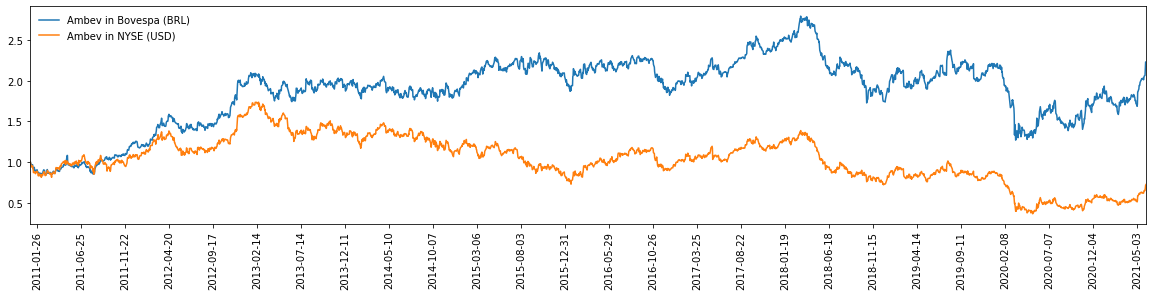

In [9]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)


for market_index in df_return_in_period.columns:
    ax.plot(df_return_in_period[market_index], label=market_index)

date_min = df_return_in_period.index.min()
date_max = df_return_in_period.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

# Testando somente para o mesmo mercado

## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (01/01/2011 até 30/04/2021) e de validação do modelo (01/05/2021 até 30/05/2021).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [10]:
df

,Ambev in Bovespa (BRL),Ambev in NYSE (USD)
Date,,
2011-01-03,8.690246,5.330
2011-01-04,8.692244,5.244
2011-01-05,8.530425,5.172
2011-01-06,8.450515,5.096
2011-01-07,8.416553,5.012
...,...,...
2021-05-28,17.850000,3.460
2021-05-31,17.950001,3.460
2021-06-01,18.770000,3.660


In [13]:
var = "Ambev in Bovespa (BRL)"

df_ibovespa = df[[var]].copy()

X_train = df_ibovespa[:"2021-05-01"]
X_test = df_ibovespa["2021-05-01":]

print(f"""Base original: {df_ibovespa.shape}
X_train: {X_train.shape}
X_test: {X_test.shape}\n""")

X_train["rt"] = (np.log(X_train[var]) - np.log(X_train[var].shift(periods=1)))*100
X_train = X_train[[var, "rt"]][1:]
X_train.head()

Base original: (2581, 1)
X_train: (2557, 1)
X_test: (24, 1)



,Ambev in Bovespa (BRL),rt
Date,,
2011-01-04,8.692244,0.022988
2011-01-05,8.530425,-1.879189
2011-01-06,8.450515,-0.941183
2011-01-07,8.416553,-0.402705
2011-01-10,8.388584,-0.332856


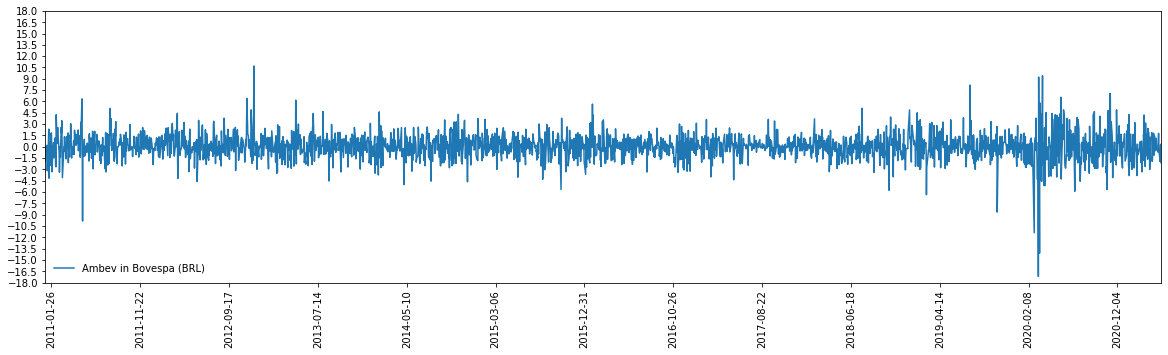

In [14]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = X_train.index.min()
date_max = X_train.index.max()

ax.plot(X_train['rt'], label=var)

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

count    2556.000000
mean        0.021199
std         1.680893
min       -17.175936
25%        -0.834515
50%         0.000000
75%         0.937135
max        10.699113
Name: rt, dtype: float64

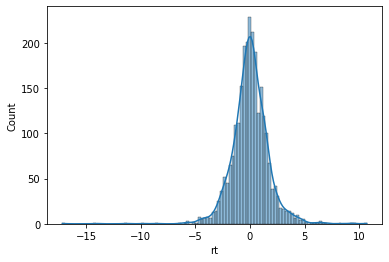

In [15]:
sns.histplot(data=X_train, x="rt", kde=True);
X_train['rt'].describe().T

### Agrupamento dos $r_{t}$

**Agrupamentos uniformes**

In [16]:
def uniform_clustering(df: pd.DataFrame, lst_columns: list) -> pd.DataFrame:
    """This function creates the target "Cluster" according to the limits described in article."""
    for column in lst_columns:
        desc = X_train['rt'].describe().T
        conditions  = [
            df[column] < desc["25%"],
            (df[column] >= desc["25%"]) & (df[column] < 0),
            (df[column] >= 0) & (df[column] < desc["75%"]),
            (df[column] >= desc["75%"])]
        choices = [ 1, 2, 3, 4]
        df["cluster_"+column] = np.select(conditions, choices, default=np.nan)

    return df

In [17]:
X_train = uniform_clustering(X_train, ["rt"])

round(X_train.groupby(by=["cluster_rt"]).agg({"rt": ["min", "max","count", "mean"]}), 2).reset_index()

cluster_rt     rt                   
                min    max count  mean
0        1.0 -17.18  -0.84   639 -1.94
1        2.0  -0.83  -0.02   578 -0.41
2        3.0   0.00   0.94   700  0.38
3        4.0   0.94  10.70   639  1.98

In [18]:
def create_rt_list(lst: list) -> list:
    rt = ["rt"]
    rt_ = ["rt-"+str(item) for item in lst]
    rt.extend(rt_)

    return rt

def create_shifted_rt(df: pd.DataFrame, rts: list) -> pd.DataFrame:
    for t in rts:
        df[f"rt-{t}"] = df["rt"].shift(periods=t)
    return df

In [20]:
X_train = df_ibovespa.loc[:"2021-05-01", [var]]
X_test = df_ibovespa.loc["2021-05-01":, [var]]

lst_shifts = np.arange(1,10,1)
lst_rts = create_rt_list(lst_shifts)

X_train["rt"] = (np.log(X_train[var]) - np.log(X_train[var].shift(periods=1)))*100
X_train = create_shifted_rt(X_train, lst_shifts)
X_train = uniform_clustering(X_train, lst_rts)

X_train.dropna(how='any', axis=0, inplace=True)
# X_train = X_train[["cluster_rt", "cluster_rt-1", "cluster_rt-5", "cluster_rt-37"]]
X_train.head(10)

,Ambev in Bovespa (BRL),rt,rt-1,rt-2,rt-3,rt-4,rt-5,rt-6,rt-7,rt-8,...,cluster_rt,cluster_rt-1,cluster_rt-2,cluster_rt-3,cluster_rt-4,cluster_rt-5,cluster_rt-6,cluster_rt-7,cluster_rt-8,cluster_rt-9
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-17,8.120885,2.339576,-1.722671,-0.862617,-3.187898,0.190347,-0.332856,-0.402705,-0.941183,-1.879189,...,4.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0,3.0
2011-01-18,7.789257,-4.169364,2.339576,-1.722671,-0.862617,-3.187898,0.190347,-0.332856,-0.402705,-0.941183,...,1.0,4.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0
2011-01-19,7.841199,0.664626,-4.169364,2.339576,-1.722671,-0.862617,-3.187898,0.190347,-0.332856,-0.402705,...,3.0,1.0,4.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0
2011-01-20,7.785262,-0.715927,0.664626,-4.169364,2.339576,-1.722671,-0.862617,-3.187898,0.190347,-0.332856,...,2.0,3.0,1.0,4.0,1.0,1.0,1.0,3.0,2.0,2.0
2011-01-21,7.593477,-2.494291,-0.715927,0.664626,-4.169364,2.339576,-1.722671,-0.862617,-3.187898,0.190347,...,1.0,2.0,3.0,1.0,4.0,1.0,1.0,1.0,3.0,2.0
2011-01-24,7.727327,1.747343,-2.494291,-0.715927,0.664626,-4.169364,2.339576,-1.722671,-0.862617,-3.187898,...,4.0,1.0,2.0,3.0,1.0,4.0,1.0,1.0,1.0,3.0
2011-01-26,7.871165,1.844307,1.747343,-2.494291,-0.715927,0.664626,-4.169364,2.339576,-1.722671,-0.862617,...,4.0,4.0,1.0,2.0,3.0,1.0,4.0,1.0,1.0,1.0
2011-01-27,7.831210,-0.508901,1.844307,1.747343,-2.494291,-0.715927,0.664626,-4.169364,2.339576,-1.722671,...,2.0,4.0,4.0,1.0,2.0,3.0,1.0,4.0,1.0,1.0
2011-01-28,7.575497,-3.319807,-0.508901,1.844307,1.747343,-2.494291,-0.715927,0.664626,-4.169364,2.339576,...,1.0,2.0,4.0,4.0,1.0,2.0,3.0,1.0,4.0,1.0


### Preparando conjunto de validação


In [22]:
X_test = df_ibovespa.loc["2021-01-01":, [var]]

X_test["rt"] = (np.log(X_test[var]) - np.log(X_test[var].shift(periods=1)))*100
X_test = create_shifted_rt(X_test, lst_shifts)
X_test = uniform_clustering(X_test, lst_rts)


X_test = X_test["2021-05-01":]
X_test.head(10)


,Ambev in Bovespa (BRL),rt,rt-1,rt-2,rt-3,rt-4,rt-5,rt-6,rt-7,rt-8,...,cluster_rt,cluster_rt-1,cluster_rt-2,cluster_rt-3,cluster_rt-4,cluster_rt-5,cluster_rt-6,cluster_rt-7,cluster_rt-8,cluster_rt-9
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-03,14.800000,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,-0.314956,1.776695,-0.701755,...,1.0,1.0,3.0,2.0,1.0,1.0,2.0,4.0,2.0,2.0
2021-05-04,14.640000,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,-0.314956,1.776695,...,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,4.0,2.0
2021-05-05,14.860000,1.491548,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,-0.314956,...,4.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,4.0
2021-05-06,16.180000,8.510291,1.491548,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,...,4.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0
2021-05-07,16.209999,0.185235,8.510291,1.491548,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,...,3.0,4.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0
2021-05-10,16.500000,1.773210,0.185235,8.510291,1.491548,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,...,4.0,3.0,4.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0
2021-05-11,16.870001,2.217657,1.773210,0.185235,8.510291,1.491548,-1.086966,-0.941496,-2.119289,0.328193,...,4.0,4.0,3.0,4.0,4.0,1.0,1.0,1.0,3.0,2.0
2021-05-12,16.870001,0.000000,2.217657,1.773210,0.185235,8.510291,1.491548,-1.086966,-0.941496,-2.119289,...,3.0,4.0,4.0,3.0,4.0,4.0,1.0,1.0,1.0,3.0
2021-05-13,16.879999,0.059249,0.000000,2.217657,1.773210,0.185235,8.510291,1.491548,-1.086966,-0.941496,...,3.0,3.0,4.0,4.0,3.0,4.0,4.0,1.0,1.0,1.0


## Treinando um modelo

Vamos testar primeiro um Naive Bayes:

In [36]:
["cluster_"+item for item in lst_rts[1:]]

['cluster_rt-1',
 'cluster_rt-2',
 'cluster_rt-3',
 'cluster_rt-4',
 'cluster_rt-5',
 'cluster_rt-6',
 'cluster_rt-7',
 'cluster_rt-8',
 'cluster_rt-9']

In [37]:
model = GaussianNB()
model.fit(X_train[["cluster_"+item for item in lst_rts[1:]]], X_train["cluster_rt"])

GaussianNB()

### Prevendo e avaliando preliminarmente

Primeiro, vamos ver como fica a acurácia e a proporção de acertos por classe.

In [59]:
y_pred_proba.reshape(len(X_test_), -1)

array([[1.02765341e-01, 5.79067676e-04, 4.84024147e-03, 8.91815350e-01],
       [1.56737317e-01, 1.05514951e-03, 2.80457854e-03, 8.39402955e-01],
       [3.51352571e-01, 2.40955342e-03, 1.54694430e-02, 6.30768432e-01],
       [2.29903961e-01, 2.02864045e-03, 9.74333376e-03, 7.58324065e-01],
       [2.18228661e-01, 7.26424387e-04, 2.27870287e-03, 7.78766212e-01],
       [3.10268287e-01, 1.39028585e-03, 1.09317206e-03, 6.87248255e-01],
       [6.35183128e-01, 5.72780129e-03, 4.32180191e-02, 3.15871051e-01],
       [3.41041943e-01, 2.27544584e-02, 3.27378082e-02, 6.03465791e-01],
       [1.17289422e-01, 2.46728448e-03, 8.41585361e-03, 8.71827440e-01],
       [4.05057308e-01, 1.33328135e-02, 3.58575593e-02, 5.45752319e-01],
       [4.88449286e-01, 2.28283095e-02, 2.26509366e-02, 4.66071468e-01],
       [1.85977721e-01, 5.04259770e-02, 1.72313511e-01, 5.91282792e-01],
       [3.38559947e-01, 5.41782420e-02, 1.76270459e-02, 5.89634765e-01],
       [2.89816227e-01, 6.81461692e-02, 1.07916841e

In [56]:
y_pred_proba

array([[1.02765341e-01, 5.79067676e-04, 4.84024147e-03, 8.91815350e-01],
       [1.56737317e-01, 1.05514951e-03, 2.80457854e-03, 8.39402955e-01],
       [3.51352571e-01, 2.40955342e-03, 1.54694430e-02, 6.30768432e-01],
       [2.29903961e-01, 2.02864045e-03, 9.74333376e-03, 7.58324065e-01],
       [2.18228661e-01, 7.26424387e-04, 2.27870287e-03, 7.78766212e-01],
       [3.10268287e-01, 1.39028585e-03, 1.09317206e-03, 6.87248255e-01],
       [6.35183128e-01, 5.72780129e-03, 4.32180191e-02, 3.15871051e-01],
       [3.41041943e-01, 2.27544584e-02, 3.27378082e-02, 6.03465791e-01],
       [1.17289422e-01, 2.46728448e-03, 8.41585361e-03, 8.71827440e-01],
       [4.05057308e-01, 1.33328135e-02, 3.58575593e-02, 5.45752319e-01],
       [4.88449286e-01, 2.28283095e-02, 2.26509366e-02, 4.66071468e-01],
       [1.85977721e-01, 5.04259770e-02, 1.72313511e-01, 5.91282792e-01],
       [3.38559947e-01, 5.41782420e-02, 1.76270459e-02, 5.89634765e-01],
       [2.89816227e-01, 6.81461692e-02, 1.07916841e

In [61]:
y_pred = model.predict(X_test[lst_rts[1:]])
y_pred_proba = model.predict_proba(X_test[lst_rts[1:]])
X_test_ = X_test.copy()
# X_test_ = X_test_[["rt", "rt-1", "rt-5", "rt-37"]]
X_test_["y_pred"] = y_pred
# X_test_["y_pred_proba"] = y_pred_proba.reshape(len(X_test_), 4)

X_test_.head()

,Ambev in Bovespa (BRL),rt,rt-1,rt-2,rt-3,rt-4,rt-5,rt-6,rt-7,rt-8,...,cluster_rt-1,cluster_rt-2,cluster_rt-3,cluster_rt-4,cluster_rt-5,cluster_rt-6,cluster_rt-7,cluster_rt-8,cluster_rt-9,y_pred
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-03,14.800000,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,-0.314956,1.776695,-0.701755,...,1.0,3.0,2.0,1.0,1.0,2.0,4.0,2.0,2.0,4.0
2021-05-04,14.640000,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,-0.314956,1.776695,...,1.0,1.0,3.0,2.0,1.0,1.0,2.0,4.0,2.0,4.0
2021-05-05,14.860000,1.491548,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,-0.314956,...,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,4.0,4.0
2021-05-06,16.180000,8.510291,1.491548,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,...,4.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,4.0
2021-05-07,16.209999,0.185235,8.510291,1.491548,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,...,4.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,4.0


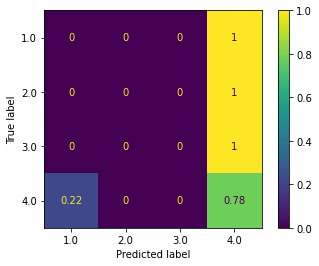

In [62]:
plot_confusion_matrix(model, X_test_[lst_rts[1:]], X_test_["cluster_rt"], normalize='true');

In [63]:
y_pred = model.predict(X_test[lst_rts[1:]])

In [67]:
X_test[lst_rts[1:]]

,rt-1,rt-2,rt-3,rt-4,rt-5,rt-6,rt-7,rt-8,rt-9
Date,,,,,,,,,
2021-05-03,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,-0.314956,1.776695,-0.701755,-0.444026
2021-05-04,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,-0.314956,1.776695,-0.701755
2021-05-05,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,-0.314956,1.776695
2021-05-06,1.491548,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983,-0.314956
2021-05-07,8.510291,1.491548,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068,-1.653983
2021-05-10,0.185235,8.510291,1.491548,-1.086966,-0.941496,-2.119289,0.328193,-0.524591,-1.943068
2021-05-11,1.773210,0.185235,8.510291,1.491548,-1.086966,-0.941496,-2.119289,0.328193,-0.524591
2021-05-12,2.217657,1.773210,0.185235,8.510291,1.491548,-1.086966,-0.941496,-2.119289,0.328193
2021-05-13,0.000000,2.217657,1.773210,0.185235,8.510291,1.491548,-1.086966,-0.941496,-2.119289


In [70]:
accuracy_score(X_test_["cluster_rt"], X_test_["y_pred"], normalize=True)

0.2916666666666667

In [71]:
rt_mean = round(X_train.groupby(by=["cluster_rt"]).agg({"rt": ["min", "max","count", "mean"]}), 2)[("rt", "mean")]

conditions = [X_test_["y_pred"]==1.0, X_test_["y_pred"]==2.0, X_test_["y_pred"]==3.0, X_test_["y_pred"]==4.0]
choices = rt_mean.tolist()
X_test_["rt_predict"] = np.select(conditions, choices, default=np.nan)

rmse_uniform = mean_squared_error(X_test_["rt"], X_test_["rt_predict"], squared=False)
print(f"RMSE para esse método: {round(rmse_uniform, 4)}%")

RMSE para esse método: 2.4296%


## Achando a estrutura da rede

In [72]:
sequencia = np.arange(1, 10, 1)
# sequencia = [1,5,37]
sequencia_rt = list(["rt-"+str(_) for _ in sequencia][::-1])
sequencia_rt.append('rt')

print(f"""\nTamanho da sequência: {len(sequencia)}
Sequência: {sequencia_rt}""")


Tamanho da sequência: 9
Sequência: ['rt-9', 'rt-8', 'rt-7', 'rt-6', 'rt-5', 'rt-4', 'rt-3', 'rt-2', 'rt-1', 'rt']


In [73]:
X_train_network = X_train[["rt"]].copy()
X_train_network = create_shifted_rt(X_train_network, sequencia)
X_train_network = uniform_clustering(X_train_network, sequencia_rt)

X_train_network.dropna(how="any", axis=0, inplace=True)
# X_train_network = X_train_network.sample(100, random_state=0).copy()
X_train_network = X_train_network.iloc[-200:,]
X_train_network = X_train_network[[column for column in X_train_network.columns if 'cluster_' in column]]

print(f"Tamanho: {X_train_network.shape}")

X_train_network.tail(10)

Tamanho: (200, 10)


,cluster_rt-9,cluster_rt-8,cluster_rt-7,cluster_rt-6,cluster_rt-5,cluster_rt-4,cluster_rt-3,cluster_rt-2,cluster_rt-1,cluster_rt
Date,,,,,,,,,,
2021-04-16,4.0,3.0,1.0,4.0,2.0,4.0,3.0,4.0,3.0,2.0
2021-04-19,3.0,1.0,4.0,2.0,4.0,3.0,4.0,3.0,2.0,2.0
2021-04-20,1.0,4.0,2.0,4.0,3.0,4.0,3.0,2.0,2.0,2.0
2021-04-22,4.0,2.0,4.0,3.0,4.0,3.0,2.0,2.0,2.0,4.0
2021-04-23,2.0,4.0,3.0,4.0,3.0,2.0,2.0,2.0,4.0,2.0
2021-04-26,4.0,3.0,4.0,3.0,2.0,2.0,2.0,4.0,2.0,1.0
2021-04-27,3.0,4.0,3.0,2.0,2.0,2.0,4.0,2.0,1.0,1.0
2021-04-28,4.0,3.0,2.0,2.0,2.0,4.0,2.0,1.0,1.0,2.0
2021-04-29,3.0,2.0,2.0,2.0,4.0,2.0,1.0,1.0,2.0,3.0


### Considerando que as variáveis impactam diretamente o target

Ou seja:
(rt-x -> rt), (rt-y -> rt), (rt-z -> rt)...


In [74]:
lst_sequence = []

for column in X_train_network.columns[:-1]:
    lst_sequence.append((column, "cluster_rt"))

lst_sequence

[('cluster_rt-9', 'cluster_rt'),
 ('cluster_rt-8', 'cluster_rt'),
 ('cluster_rt-7', 'cluster_rt'),
 ('cluster_rt-6', 'cluster_rt'),
 ('cluster_rt-5', 'cluster_rt'),
 ('cluster_rt-4', 'cluster_rt'),
 ('cluster_rt-3', 'cluster_rt'),
 ('cluster_rt-2', 'cluster_rt'),
 ('cluster_rt-1', 'cluster_rt')]

In [75]:
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel

k2 = K2Score(X_train_network)

lst_temp = []
selected_columns = ["cluster_rt"]
df_result = pd.DataFrame(columns=["k2", "variables"])

for i, item in enumerate(lst_sequence):
    lst_temp.append(lst_sequence[len(lst_sequence)-i-1])
    selected_columns.append(lst_sequence[len(lst_sequence)-i-1][0])

    k2 = K2Score(X_train_network[selected_columns])
    model1 = BayesianModel(lst_temp)
    df_result.loc[i, "k2"] = k2.score(model1)
    df_result.loc[i, "variables"] = str(lst_temp)

df_result.sort_values(by="k2", ascending=False)

,k2,variables
0,-548.850071,"[('cluster_rt-1', 'cluster_rt')]"
1,-820.258691,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
2,-1095.212255,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
3,-1370.695149,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
4,-1641.70667,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
5,-1911.114769,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
6,-2182.170039,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
7,-2452.175027,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
8,-2721.738998,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."


### Considerando que as variáveis impactam a seguinte

Ou seja:
(rt-10 -> rt-9), (rt-9 -> rt-8), (rt-8 -> rt-7)...

In [76]:
X_train_network

,cluster_rt-9,cluster_rt-8,cluster_rt-7,cluster_rt-6,cluster_rt-5,cluster_rt-4,cluster_rt-3,cluster_rt-2,cluster_rt-1,cluster_rt
Date,,,,,,,,,,
2020-07-07,1.0,4.0,1.0,4.0,1.0,4.0,1.0,2.0,4.0,3.0
2020-07-08,4.0,1.0,4.0,1.0,4.0,1.0,2.0,4.0,3.0,4.0
2020-07-09,1.0,4.0,1.0,4.0,1.0,2.0,4.0,3.0,4.0,2.0
2020-07-10,4.0,1.0,4.0,1.0,2.0,4.0,3.0,4.0,2.0,4.0
2020-07-13,1.0,4.0,1.0,2.0,4.0,3.0,4.0,2.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-04-26,4.0,3.0,4.0,3.0,2.0,2.0,2.0,4.0,2.0,1.0
2021-04-27,3.0,4.0,3.0,2.0,2.0,2.0,4.0,2.0,1.0,1.0
2021-04-28,4.0,3.0,2.0,2.0,2.0,4.0,2.0,1.0,1.0,2.0


In [77]:
lst_sequence = []
n = len(X_train_network.columns)-1

for i, column in enumerate(X_train_network.columns[::-1]):
    lst_sequence.append((X_train_network.columns[n-(1+i)], X_train_network.columns[n-i]))

lst_sequence.pop()

('cluster_rt', 'cluster_rt-9')

In [34]:
k2 = K2Score(X_train_network)

lst_temp = []
df_result = pd.DataFrame(columns=["k2", "variables"])

for i, item in enumerate(lst_sequence):
    lst_temp.append(lst_sequence[i])
    print(lst_temp)
    k2 = K2Score(X_train_network)
    model1 = BayesianModel(lst_temp)
    df_result.loc[i, "k2"] = k2.score(model1)
    df_result.loc[i, "variables"] = str(lst_temp)

df_result.sort_values(by="k2", ascending=False)

[('cluster_rt-1', 'cluster_rt')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1'), ('cluster_rt-5', 'cluster_rt-3')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1'), ('cluster_rt-5', 'cluster_rt-3'), ('cluster_rt-7', 'cluster_rt-5')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1'), ('cluster_rt-5', 'cluster_rt-3'), ('cluster_rt-7', 'cluster_rt-5'), ('cluster_rt-9', 'cluster_rt-7')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1'), ('cluster_rt-5', 'cluster_rt-3'), ('cluster_rt-7', 'cluster_rt-5'), ('cluster_rt-9', 'cluster_rt-7'), ('cluster_rt-11', 'cluster_rt-9')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1'), ('cluster_rt-5', 'cluster_rt-3'), ('cluster_rt-7', 'cluster_rt-5'), ('cluster_rt-9', 'cluster_rt-7'), ('cluster_rt-11', 'cluster_rt-9'), ('cluster_rt-13', 'cluster_rt-11')]


,k2,variables
0,-548.850071,"[('cluster_rt-1', 'cluster_rt')]"
1,-822.446963,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
2,-1097.23957,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
3,-1371.780783,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
4,-1643.753516,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
5,-1913.737901,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
6,-2183.699624,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
